# Introduction

Welcome to my kernel on time series forecasting to predict the demand on electricty demand in the Great Britain. I will use the historic electricity demand data from the [UK National Grid](https://data.nationalgrideso.com). I will follow the next steps:
* Perform **[EDA and Feature Engineering](#eda)** to clean the dataset, add new features to improve the prediction and understand the trend and seasonality of the electricity demand




#  Table of contents
* [EDA and Feature Engineering](#eda_fe)


In [1]:
!pip install pmdarima
!pip install workalendar
!pip install prophet
!pip install -q --upgrade linear-tree

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 7.3 MB/s eta 0:00:00


In [2]:
import datetime
import json
import os
from joblib import Parallel, delayed
from time import sleep, time
import logging


import itertools
import holidays
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import requests
import seaborn as sns
import statsmodels
import statsmodels.tsa.api as sm
import tensorflow as tf
import xgboost as xgb
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from lineartree import LinearBoostRegressor
from matplotlib import rcParams  # Used to set default paremeters
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf, quarter_plot
from workalendar.europe import UnitedKingdom

<a id="eda_fe"></a>
## Figure default parameters

Throughout the notebook I will create manuy figures. In order to save time and avoid having to set the parameters for each plot, I will define the default font and font sizes for all the plots.


In [3]:
sns.set_style("whitegrid")

# Set Default Fonts
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# # Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize

# Load data

I initially used [the National Grid](https://data.nationalgrideso.com) API to acess the historic electricity demand between 2009 and 2022. I uploaded the [dataset](https://www.kaggle.com/datasets/albertovidalrod/electricity-consumption-uk-20092022) to Kaggle and I will be using it in this notebook.

In [4]:
df = pd.read_csv("historic_demand_2009_2023.csv", index_col=0)

# Change column names to lower case and drop id (row number)
df.columns = df.columns.str.lower()

<a id='eda'></a>
# EDA and Feature engineering

In this section, I will go through several steps to understand and transform the original dataset. The steps I will follow are:
* Data understanding. Have a first look at the timeseries dataset
* Data preparation. Deal with null values, drop uninformative features and remove outliers
* Feature understanding. Understand the trend and different seasonalities in the data

## Data understanding

The [dataset](https://www.kaggle.com/datasets/albertovidalrod/electricity-consumption-uk-20092022) includes a description of all the columns, but for this project I will only use three columns:

* SETTLEMET_DATA: date in format dd/mm/yyyy
* SETTLEMENT_PERIOD: half hourly period for the historic outtunr occurred
* TSD (Transmission System Demand). Transmission System Demand is equal to the ND plus the additional generation required to meet station load, pump storage pumping and interconnector exports. Measured in MW.

TSD is target variable and the aim is to predict the future demand using different models.


Let's have a quick look at the data and the their statistics:

In [5]:
df.sample(n=7)

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,is_holiday
146511,2017-05-11,18,32845,33390,29624,791,5108,2930,12000,122,8,1997,0,965,-159,0,0,NaN,NaN,0
235417,2022-06-06,28,29063,30433,26397,785,6545,3778,13859,0,5,262,251,1060,-254,-531,999,0.0,-80.0,0
164369,2018-05-18,20,30118,31306,27022,333,5859,5630,13052,0,9,1996,0,596,-302,-377,0,NaN,NaN,0
5667,2009-04-29,6,27171,29351,24531,73,1613,0,0,0,1479,633,0,0,-201,0,0,NaN,NaN,0
81764,2013-08-30,48,25758,26515,23598,836,2450,0,2939,0,12,1368,0,879,0,-245,0,NaN,NaN,0
152691,2017-09-17,6,20615,22243,18750,513,5305,0,12372,0,1129,802,0,721,248,504,0,NaN,NaN,0
122277,2015-12-23,22,35357,36322,32447,2973,4013,2360,9063,0,10,1996,0,971,-189,-166,0,NaN,NaN,0


In [6]:
df.describe()

,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,is_holiday
count,255070.000000,255070.000000,255070.000000,255070.000000,255070.000000,255070.000000,255070.000000,255070.000000,255070.000000,255070.000000,255070.000000,255070.000000,255070.000000,255070.000000,255070.000000,255070.000000,79774.000000,79774.000000,255070.000000
mean,24.500039,31679.906238,33071.591210,28819.173580,1213.223362,4247.810052,821.071267,7851.549332,7.285388,316.532662,920.043071,18.792775,537.603187,-111.227157,-28.657369,153.303427,227.102703,-24.863013,0.022958
std,13.853711,7806.148116,7729.068809,7077.277667,923.193363,1932.010954,1630.590692,5491.807479,40.909337,541.249843,1089.290031,316.160421,512.080517,224.534212,252.245598,391.440777,523.590631,391.028808,0.149771
min,1.000000,13367.000000,0.000000,0.000000,0.000000,1403.000000,0.000000,0.000000,-24.000000,0.000000,-2056.000000,-1030.000000,-1215.000000,-505.000000,-585.000000,-1022.000000,-1455.000000,-1028.000000,0.000000
25%,12.250000,25428.000000,27051.000000,23128.000000,525.000000,2085.000000,0.000000,1841.000000,0.000000,8.000000,217.000000,0.000000,0.000000,-252.000000,-139.000000,0.000000,0.000000,0.000000,0.000000
50%,24.000000,31096.000000,32294.000000,28270.000000,973.000000,4253.000000,0.000000,9600.000000,0.000000,12.000000,1244.000000,0.000000,760.000000,-125.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,36.000000,37426.000000,38572.000000,34072.000000,1647.000000,6439.000000,771.000000,13080.000000,0.000000,429.000000,1898.000000,0.000000,994.000000,41.000000,1.000000,0.000000,693.000000,0.000000,0.000000
max,50.000000,59095.000000,60147.000000,53325.000000,5354.000000,6574.000000,9830.000000,14285.000000,893.000000,2019.000000,2066.000000,1016.000000,1143.000000,499.000000,504.000000,1033.000000,1401.000000,1002.000000,1.000000


In [7]:
df.shape

(255070, 20)

Let's sort the values by date as some of them have been misplaced in the original dataset

In [8]:
# Sort values by date
df.sort_values(
    by=["settlement_date", "settlement_period"], inplace=True, ignore_index=True
)

## Data preparation

The goal of this section is to prepare the data for the model. To do so, I will perform the following actions:
* Find out how many `nan` values there are and drop the columns containing `nan` values
* Drop rows whose `settlement_period` exceeds 48, as the API states that 48 is the maximum number of samples per day
* Remove outliers

As a bonus, I will add a new feature at this point, bank holidays in the UK. The reason to add them at this point is that I will trasnform the date format for better analysis in a future section. Therefore, it's easier for me to add the bank holidays while performing data preparation.

Let's begin checking if there are`nan` values:

In [9]:
df.isna().any()

settlement_date              False
settlement_period            False
nd                           False
tsd                          False
england_wales_demand         False
embedded_wind_generation     False
embedded_wind_capacity       False
embedded_solar_generation    False
embedded_solar_capacity      False
non_bm_stor                  False
pump_storage_pumping         False
ifa_flow                     False
ifa2_flow                    False
britned_flow                 False
moyle_flow                   False
east_west_flow               False
nemo_flow                    False
nsl_flow                      True
eleclink_flow                 True
is_holiday                   False
dtype: bool

As can be seen, only two columns include `nan` values. Let's check how many `nan` values there are in each column:

In [10]:
pd.concat(
    [
        df["nsl_flow"].isna().value_counts().to_frame(),
        df["eleclink_flow"].isna().value_counts().to_frame(),
    ],
    axis=1,
    ignore_index=True,
).rename(columns={0: "nsl_flow", 1: "eleclink_flow"})

,nsl_flow,eleclink_flow
True,175296,175296
False,79774,79774


It seems that both features have the same number of `nan` values. Let's have a look at that the dataframe containing the `nan` value:

In [11]:
df.loc[(df["eleclink_flow"].isna()) | (df["nsl_flow"].isna()), :]

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,is_holiday
0,2009-01-01,1,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,NaN,NaN,1
1,2009-01-01,2,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,NaN,NaN,1
2,2009-01-01,3,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,NaN,NaN,1
3,2009-01-01,4,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,NaN,NaN,1
4,2009-01-01,5,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175291,2018-12-31,44,26826,28428,25195,2734,5918,0,13052,0,13,1960,0,777,-454,-535,0,NaN,NaN,0
175292,2018-12-31,45,25660,27542,24145,2730,5918,0,13052,0,23,1182,0,-268,-455,-536,0,NaN,NaN,0
175293,2018-12-31,46,25047,26971,23496,2726,5918,0,13052,0,36,1157,0,-297,-455,-536,0,NaN,NaN,0
175294,2018-12-31,47,24188,26224,22683,2673,5918,0,13052,0,49,1546,0,-467,-454,-466,0,NaN,NaN,0


It seems that neither feature existed from 2009 to 2018. The best thing is to drop these features. 

Also, I will remove the rows where the `settlement_period` exceeds 48, as the maximum number is 48. Any values larger than 48 is a fault when logging the data.

In [12]:
df.drop(columns=["nsl_flow", "eleclink_flow"], axis=1, inplace=True)

# Drop rows where settlement_period value is greater than 48
df.drop(index=df[df["settlement_period"] > 48].index, inplace=True)

df.reset_index(drop=True, inplace=True)

### Bank holidays

Bank holidays are very important in time series forecasting as they often affect the data values on those days. Therefore, I want to add a new column to my dataset to state whether each day was bank holiday or not. I began by checking the [UK governement bank holiday API](https://github.com/alphagov/calendars), but it only goes back to 2015. 

My next option was to check StackOverflow and [oen of the questions](https://stackoverflow.com/questions/37677112/adding-holidays-columns-in-a-dataframe-in-python) was related to this issue. The asnwers suggest using [Python Workalendar](https://workalendar.github.io/workalendar/), but for some reason it was adding more bank holidays than it should (I verified this using other websites). 

Luckily, an entry in [Stack Exchange](https://opendata.stackexchange.com/a/13215) covered this topic too and one of the answers suggested using [Python holidays](https://github.com/dr-prodigy/python-holidays), which after checking the [Python Holidays API](https://python-holidays.readthedocs.io/en/latest/api.html) I managed to make work for my usecase.

Since the dataset covers electricity demand for England and Wales, the first step is to check that the two countries have the same bank holidays:

In [13]:
# Compare England's and Wales' bank holiday
bank_holiday_england = holidays.UK(
    subdiv="England", years=range(2009, 2024), observed=True
).items()
bank_holiday_wales = holidays.UK(
    subdiv="Wales", years=range(2009, 2024), observed=True
).items()

print(bank_holiday_england == bank_holiday_wales)

True


Having seen that the bank holidays are the same, I can proceed with this python package to extract the bank holidays and store them in the right format.

It's worth noting that this package includes the original bank holiday and when it was observed. I will only store the observed days.

In [14]:
# Create empty lists to store data
holiday_names = []
holiday_dates = []
holiday_names_observed = []
holiday_dates_observed = []

for date, name in sorted(bank_holiday_england):
    holiday_dates.append(date)
    holiday_names.append(name)
    # Pop the previous value as observed bank holidays takes place later
    if "Observed" in name:
        holiday_dates_observed.pop()
        holiday_names_observed.pop()

    holiday_names_observed.append(name)
    holiday_dates_observed.append(np.datetime64(date))

holiday_dates_observed[:5]

[numpy.datetime64('2009-01-01'),
 numpy.datetime64('2009-04-10'),
 numpy.datetime64('2009-04-13'),
 numpy.datetime64('2009-05-04'),
 numpy.datetime64('2009-05-25')]

Once I've verified that the holidays are correctly loaded, one can compare the `holiday_dates` variable and the date in the dataset and store the boolean output in a new column: 

In [15]:
df["is_holiday"] = df["settlement_date"].apply(
    lambda x: pd.to_datetime(x) in holiday_dates_observed
)

df["is_holiday"] = df["is_holiday"].astype(int)

df[df["is_holiday"] == 1].sample(7)

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
175292,2019-01-01,17,23205,24640,21313,1606,5918,6,13052,0,14,1651,0,162,-456,-365,0,1
245159,2022-12-27,4,21358,23610,19660,1709,6545,0,13861,0,787,413,332,0,-396,-169,-300,1
157505,2017-12-26,36,36314,36965,32276,1272,5754,1,12916,297,15,1996,0,990,-333,178,0,1
17542,2010-01-01,25,38636,39675,34667,703,1786,0,0,0,8,1998,0,0,-431,0,0,1
250193,2023-04-10,48,19638,22857,18225,2939,6545,0,13080,0,407,-1184,5,103,-451,-524,-153,1
182304,2019-05-27,23,23178,23692,19925,1947,6137,6170,13080,0,14,1499,0,756,98,166,641,1
232868,2022-04-15,1,22430,25738,20312,704,6545,0,13787,0,11,-843,-1017,-436,200,0,-501,1


The sample dataframe above is ok to make sure that the new column has been created, but one can inspect the bank holidays more easily using a plot.

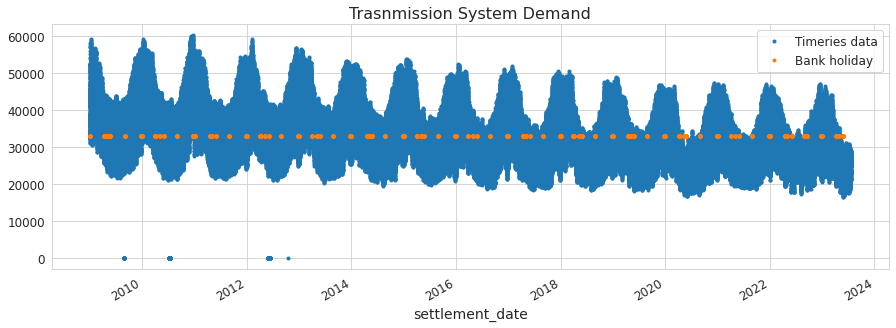

In [16]:
# Set date as the index and turn into datetime type
df_plot = df.copy()
df_plot = df_plot.set_index("settlement_date")
df_plot.index = pd.to_datetime(df_plot.index)

fig, ax = plt.subplots(figsize=(15, 5))
df_plot["tsd"].plot(
    style=".", ax=ax, title="Trasnmission System Demand", label="Timeries data"
)
(df_plot.query("is_holiday == 1")["is_holiday"] * 33000).plot(
    style=".", ax=ax, label="Bank holiday"
)
ax.legend();

That plot is great to see the behaviour of the time series data. I can see a decreasing trend and a clear yearly seasonality. However, this plot also shows the presence of data points equal to 0. These values will be removed in the next section.

Before dealing with outliers, in the above graph we can see a yearly trend, but we cannot focus on daily or weekly patterns. Therefore, let's create a new plot focusing on a single week:

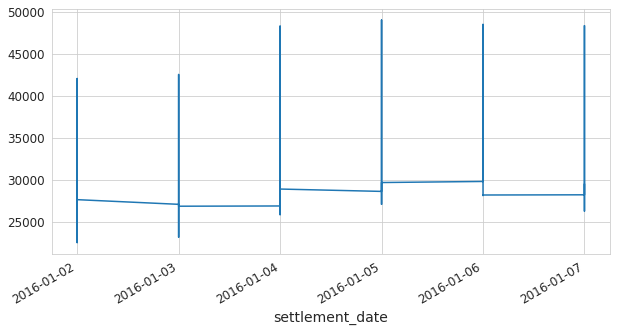

In [17]:
df_plot.loc[(df_plot.index > "01-01-2016") & (df_plot.index < "01-08-2016")][
    "tsd"
].plot(figsize=(10, 5));

This plot isn't what I was expecting... Am I plotting the right parameter or is there something wrong in the dataset? One can begin by inspecting the dataframe:

In [18]:
df_plot.head()

,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
settlement_date,,,,,,,,,,,,,,,,,
2009-01-01,1,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,1
2009-01-01,2,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,1
2009-01-01,3,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,1
2009-01-01,4,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,1
2009-01-01,5,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,1


The plot wasn't wrong! In the process of seeting the date as the index I haven't added the hour. Therefore, the 48 samples per day are overlayed on top of each other.

Before going forward I need to do two things:
* Remove outliers
* Add the hour to the date and set it as the index

### Outlier analysis

In the plot above, one can see that there are multiple 0 values. A histogram will show how many samples are actually equal to 0.

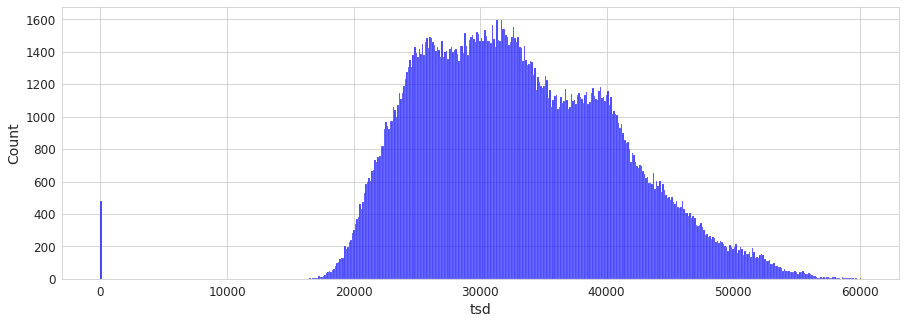

In [19]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.histplot(data=df, x="tsd", bins=500, ax=ax, color="b");

I will not only delete the values equal to 0 but the entire day where there are values equal to 0. The reason being that otherwise the remaining daily values would not be representative of the entire day, which becomes more relevant for the SARIMA models as I will be using daily data instead of hourly.

In [20]:
null_days = df.loc[df["tsd"] == 0.0, "settlement_date"].unique().tolist()

null_days_index = []

for day in null_days:
    null_days_index.append(df[df["settlement_date"] == day].index.tolist())

null_days_index = [item for sublist in null_days_index for item in sublist]

df.drop(index=null_days_index, inplace=True)
df.reset_index(drop=True, inplace=True)

## Feature creation

The first step in the feature creation is to change the date format to include the hourly values. The `settlement_period` values refer to how many samples have been taken per day. Given that there are 48 samples per day, each sample represents 30 minutes of the day. Using this information together with the valuable knowledge of the [StackOverflow](https://stackoverflow.com/questions/61444409/convert-a-pandas-column-to-hours-and-minutes) [contributors](https://stackoverflow.com/questions/51846547/how-to-convert-float-into-hours-minutes-seconds), I managed to change the date format.

In [21]:
# Apply lambda function to turn settlement period into hours.
# Settlement period equal to 0 corresponds with 00:00:00 and each
# settlement period adds 30 minutes until settlement period 48, which
# corresponds with 23:30:00
df["period_hour"] = (df["settlement_period"]).apply(
    lambda x: str(datetime.timedelta(hours=(x - 1) * 0.5))
)

df.loc[df["period_hour"] == "1 day, 0:00:00", "period_hour"] = "0:00:00"

# Move the new column
column_to_move = df.pop("period_hour")
df.insert(2, "period_hour", column_to_move)

df.sample(n=7)

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
246016,2023-01-28,45,22:00:00,29290,30737,27037,1120,6545,0,13080,0,7,241,-274,1003,-451,-115,277,0
244568,2022-12-29,37,18:00:00,34272,35747,31466,3045,6545,0,13861,0,2,1005,991,1004,-451,-422,1019,0
207179,2020-11-10,36,17:30:00,40936,41540,37535,1296,6527,0,13080,0,4,2005,0,1057,97,504,989,0
24833,2010-06-04,22,10:30:00,38982,39847,35391,200,2056,3,27,30,5,845,0,0,-390,0,0,0
27587,2010-08-04,40,19:30:00,34670,35504,31708,1289,2092,1,37,0,4,1990,0,0,-330,0,0,0
177433,2019-03-01,46,22:30:00,29195,29991,26223,1237,6192,0,13080,111,6,1997,0,1000,-260,-41,908,0
15148,2009-11-14,31,15:00:00,37118,37883,33618,1506,1740,0,0,0,5,1892,0,0,-160,0,0,0


As can be seen, a new column called `period_hour` includes the hour at which the electricity demand measurement was taken. One can now combine it with the actual date as follows:

In [22]:
df["settlement_date"] = pd.to_datetime(
    (df["settlement_date"] + " " + df["period_hour"])
)

df.sample(n=5)

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
97890,2014-08-17 15:00:00,31,15:00:00,26185,26899,23971,2189,3344,2520,5147,0,9,1996,0,1000,0,-205,0,0
173063,2018-11-30 21:30:00,44,21:30:00,32668,34273,30336,2416,5911,0,13052,0,14,1690,0,1000,-455,-536,0,0
69601,2013-01-05 04:30:00,10,4:30:00,26056,28089,23547,460,2085,0,2046,0,1235,993,0,988,-153,-45,0,0
59430,2012-06-05 07:00:00,15,7:00:00,24546,25855,21855,203,2065,99,1586,0,12,69,0,-664,-133,0,0,1
124678,2016-02-26 18:00:00,37,18:00:00,47392,48332,42895,678,4126,0,9300,0,8,1998,0,977,-99,-233,0,0


The `settlement_date` column is now in the right format to use an index:

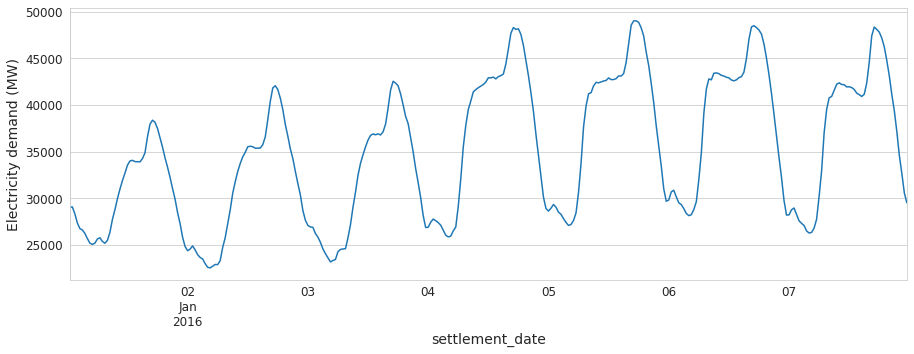

In [23]:
df.set_index("settlement_date", inplace=True)
df.sort_index(inplace=True)

df.loc[(df.index > "01-01-2016") & (df.index < "01-08-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
);

While adding extra features will not improve the prediction for the SARIMA models, XGBoost will benefit from it. The new features constits of different bits of information "already stored" in the date, such as the day of the week and the day of the year. Given the seasonality of the time series data, these features might lead to more accurate predictions. The second part is adding lags. Again, XGBoost will benefit from this.

In [24]:
def create_features(df):
    """
    Create time series features based on time series index

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with new features
    """
    df = df.copy()
    df["day_of_month"] = df.index.day
    df["day_of_week"] = df.index.day_of_week
    df["day_of_year"] = df.index.day_of_year
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["week_of_year"] = df.index.isocalendar().week.astype("int64")
    return df


def add_lags(df):
    """
    Add three lags to the dataset containing information from the previous 3 years.

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with lags
    """
    target_map = df["tsd"].to_dict()
    # 364 is chosen instead of 365 becuase 364 is divisible by 4 and that way we don't have to
    # map specific days
    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    return df

In [25]:
df = create_features(df)
df = add_lags(df)

df.sample(n=5)

,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,day_of_month,day_of_week,day_of_year,quarter,month,year,week_of_year,lag1,lag2,lag3
settlement_date,,,,,,,,,,,,,,,,,,,,,
2012-02-20 04:30:00,10,4:30:00,29880,33886,27086,637,1950,0,1367,0,...,20,0,51,1,2,2012,8,32008.0,33907.0,30291.0
2019-02-20 12:00:00,25,12:00:00,35503,36524,32937,3490,6192,2580,13080,0,...,20,2,51,1,2,2019,8,41709.0,37764.0,41029.0
2015-01-13 17:30:00,36,17:30:00,48791,50105,44478,2134,4040,0,6059,0,...,13,1,13,1,1,2015,3,52007.0,55028.0,53955.0
2012-09-28 11:30:00,24,11:30:00,38903,39662,35495,1032,2085,401,1903,0,...,28,4,272,3,9,2012,39,41189.0,43065.0,42205.0
2009-08-21 10:30:00,22,10:30:00,39029,40358,35578,787,1755,0,0,0,...,21,4,233,3,8,2009,34,NaN,NaN,NaN


## Feature understanding

In this section, I will explore the distribution of electricity demand with respect the different features, such as as hour, month or year. This is a great way to understand the seasonalities in the time series.

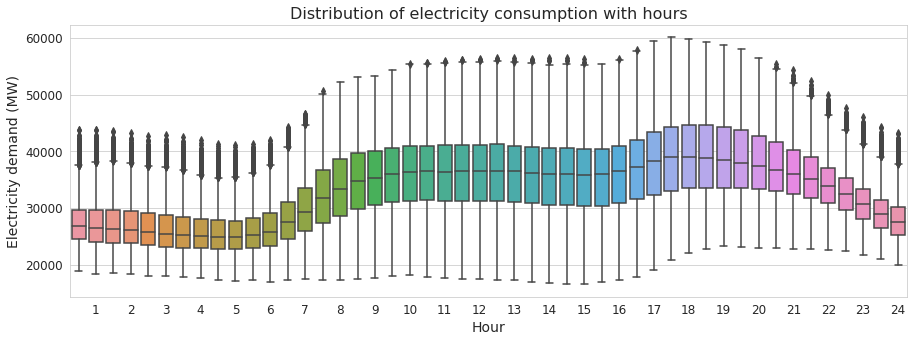

In [26]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="settlement_period", y="tsd", data=df)
# Reduce the frequency of the xticks and change the labels to be in
# the range [0,24] hours
ax.set_xticks(range(1, 49, 2))
ax.set_xticklabels(range(1, 25))
ax.set_xlabel("Hour")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with hours");

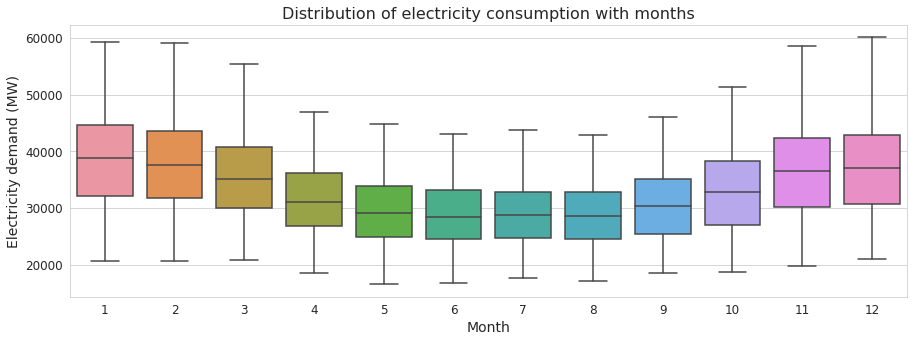

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="month", y="tsd", data=df)

ax.set_xlabel("Month")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with months");

It seems that the lowest consumption occurs during the summer months. Having grown up in Spain, this is a rare concept for me as everyone switches their AC on, resulting in higher consumption.

Let's plot on the years, for example 2016, to make sure that I selected the right variable in the above plot.

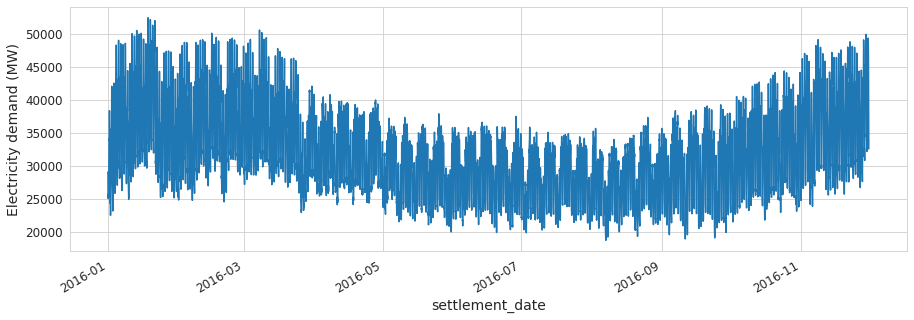

In [28]:
df.loc[(df.index > "01-01-2016") & (df.index < "12-01-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
);

This plot supports the finding from the previous graph. 

Let's look at the effect of bank holidays on electricity consumption:

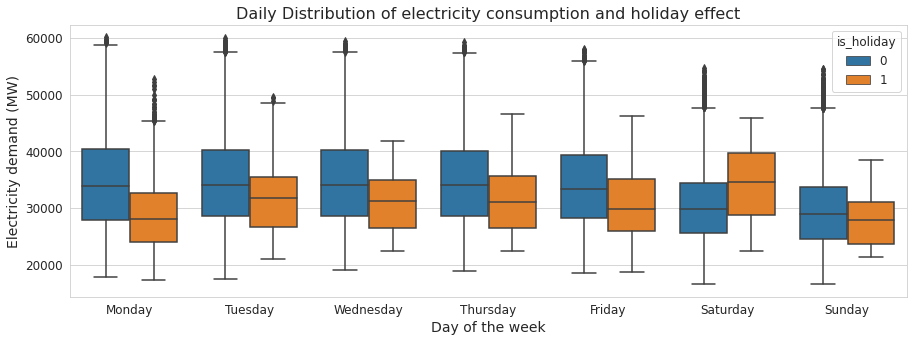

In [29]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="day_of_week", y="tsd", data=df, hue="is_holiday", ax=ax)

ax.set_xticklabels(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
ax.set_xlabel("Day of the week")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Daily Distribution of electricity consumption and holiday effect");

It seems that from Mondat to Friday, the electricity consumption is on average lower on bank holidays, whereas it is higher on Saturday and it's the same on Sundays.

For non bank holiday, the demand on the weekend is lower than during week days.

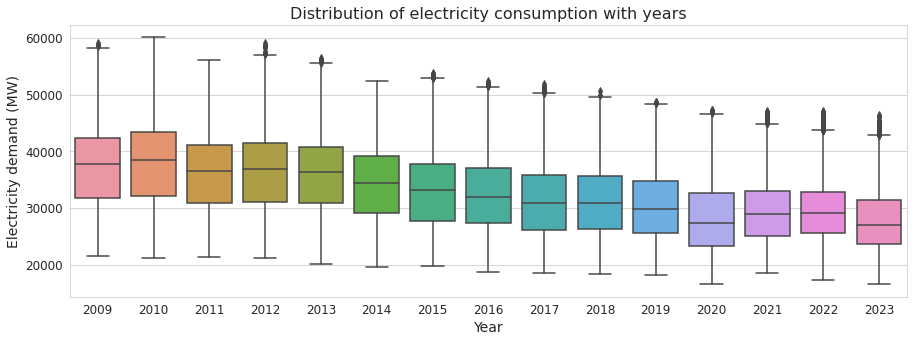

In [30]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="year", y="tsd", data=df)

ax.set_xlabel("Year")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with years");

Although these are yearly average values, one can see a decreasing trend in the electricity consumption. We can overlay the electricity consumption of two years to see how they compare:

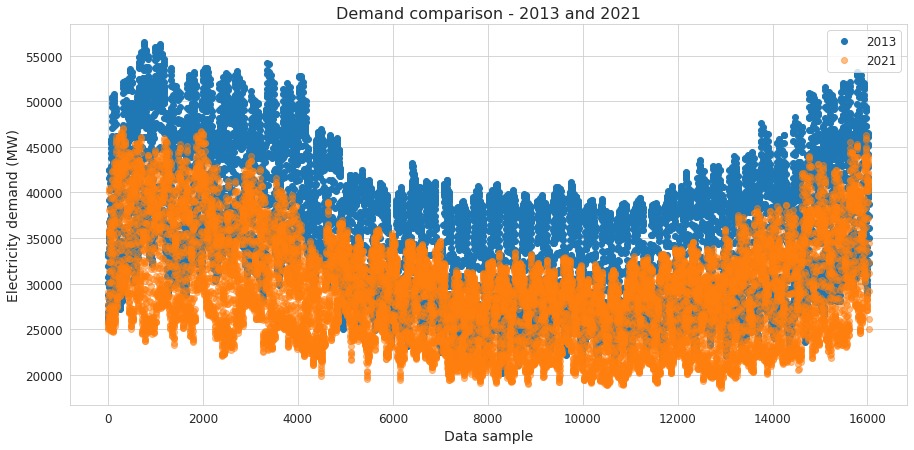

In [31]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(
    range(len(df.loc[(df.index > "01-01-2013") & (df.index < "12-01-2013")]["tsd"])),
    df.loc[(df.index > "01-01-2013") & (df.index < "12-01-2013")]["tsd"],
    "o",
    label="2013",
)

ax.plot(
    range(len(df.loc[(df.index > "01-01-2021") & (df.index < "12-01-2021")]["tsd"])),
    df.loc[(df.index > "01-01-2021") & (df.index < "12-01-2021")]["tsd"],
    "o",
    alpha=0.5,
    label="2021",
)
ax.set_xlabel("Data sample")
ax.set_ylabel("Electricity demand (MW)")
ax.legend(loc="best")
ax.set_title("Demand comparison - 2013 and 2021");

Again, this plot confirms that electricity consumption is decreasing in recent years.